In [1]:
import os
import sys

from math import cos,sin,tan,asin,acos,radians,sqrt,degrees,atan,atan2,copysign
import numpy as np

#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import pickle
import scipy
from scipy.stats import norm
import random
import time
import timeit
import math
import localization as lx
import gzip

import util.npose_util as nu
import datetime
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial import cKDTree

import tensorflow as tf
import joblib
from sklearn.manifold import MDS
import argparse
from functools import partial
from itertools import starmap,repeat,permutations,combinations

from pymol import cmd, stored, selector

import GenerateEndpoints as ge
import HelixFit as hf
import FitTransform as ft

import seaborn as sns
import util.RotationMethods as rm

#reference helix for propogation
zero_ih = nu.npose_from_file('util/zero_ih.pdb')
tt = zero_ih.reshape(int(len(zero_ih)/5),5,4)
stub = tt[7:10].reshape(15,4)

np.set_printoptions(precision=2)
%config Completer.use_jedi = False

In [2]:
#load distance maps
def load_distance_map(name, dm_file='data/Fits_4H_dm_phi.npz'):
    rr = np.load(dm_file, allow_pickle=True)
    X_train, y_train , featNames = [rr[f] for f in rr.files]
    
    
    return X_train[y_train==name][:,:-4]


In [3]:
# dm_file = 'data/Fits_4H_dm_phi.npz'
# rr = np.load(dm_file, allow_pickle=True)
# X_train, y_train , featNames = [rr[f] for f in rr.files]

In [4]:
model_direc = 'data/4H_dataset/models/'
# cmd.load(f'{model_direc}{y_train[0]}.pdb')

# cmd.save(f'output/test.pdb')

In [5]:
#endpoints for data set 
Fits4H_file = 'data/Fits_4H.csv'
dfRead = pd.read_csv(Fits4H_file)
df1 = ft.prepData_Str(dfRead,rmsd_filter=100)
df2 = ft.EndPoint(df1)
ep = df2.to_numpy()[:,:24].astype(float).reshape((-1,8,3))
X = ep

In [6]:
def index_helix_ep(ep_in,helices_desired=[0,1],num_helices=4):
    
    num_ep = num_helices*2
    hi = np.array(helices_desired,dtype=int)
    h_ep = np.array(range(num_ep)).reshape((-1,2)) #generate helix to endpoint mapping
    
    #alternate example for indexing batch of X 
    #X.reshape((X.shape[0],-1))[:,indexarray]
    
    #select desired endpoints from  batch of endpoints
    return ep_in[np.ix_(np.array(range(ep_in.shape[0])),h_ep[hi].flatten(), np.array(range(ep_in.shape[2])))]
    
def get_midpoint(ep_in,helices_desired=[0,1],num_helices=4):
    
    num_ep = num_helices*2
    
    ind_ep = index_helix_ep(ep_in, helices_desired=helices_desired, num_helices=4)
    
    #calculate midpoint
    midpoint = ind_ep.sum(axis=1)/np.repeat(ind_ep.shape[1], ind_ep.shape[2])
    
    return midpoint
    
    
    
    

In [17]:
def index_helix_ep(ep_in,helices_desired=[0,1],num_helices=4):
    
    num_ep = num_helices*2
    hi = np.array(helices_desired,dtype=int)
    h_ep = np.array(range(num_ep)).reshape((-1,2)) #generate helix to endpoint mapping
    
    #alternate example for indexing batch of X 
    #X.reshape((X.shape[0],-1))[:,indexarray]
    
    #select desired endpoints from  batch of endpoints
    return X[np.ix_(np.array(range(ep_in.shape[0])),h_ep[hi].flatten(), np.array(range(ep_in.shape[2])))]
    
def get_midpoint(ep_in,helices_desired=[0,1],num_helices=4):
    
    num_ep = num_helices*2
    
    ind_ep = index_helix_ep(ep_in, helices_desired=helices_desired, num_helices=4)
    
    #calculate midpoint
    midpoint = ind_ep.sum(axis=1)/np.repeat(ind_ep.shape[1], ind_ep.shape[2])
    
    return midpoint

def get_stubs_from_points(ep_in,index=[0,1,2]):
#def get_stubs_from_n_ca_c(n, ca, c):
    """Modified from Brian's npose code  get_stubs_from_n_ca_c, index references 3 points, to define plane.
    """
    e1 = ep_in[:,index[1]]-ep_in[:,index[0]]
    e1 = np.divide( e1, np.linalg.norm(e1, axis=1)[..., None] )

    e3 = np.cross( e1, ep_in[:,index[2]]-ep_in[:,index[0]], axis=1 )
    e3 = np.divide( e3, np.linalg.norm(e3, axis=1)[..., None] )

    e2 = np.cross( e3, e1, axis=1 )

    stub = np.zeros((len(ep_in), 4, 4))
    stub[...,:3,0] = e1
    stub[...,:3,1] = e2
    stub[...,:3,2] = e3
    stub[...,:3,3] = ep_in[:,index[1]]
    stub[...,3,3] = 1.0

    return stub

def xform_npose_2batch(xform, npose):
    #single batch code  util.npose_util as xform_npose
    return np.matmul(np.repeat(xform[:,np.newaxis,...],npose.shape[1],axis=1),npose[...,None]).squeeze(-1)

def xform_to_z_plane(mobile, index_mobile=[0,1,2]):
    """rotate points into the z-plane for trilaterization. needs additional translation/reflection"""

    mobile_stub = get_stubs_from_points(mobile, index=index_mobile)
    mobile_stub_inv = np.linalg.inv(mobile_stub)
    
    z_plane_ref = np.repeat(np.array([[[0,0,0],[1,0,0],[1,1,0]]]), mobile.shape[0],axis=0)

    ref_stub = get_stubs_from_points(z_plane_ref, index=[0,1,2])

    xform = ref_stub @ mobile_stub_inv

    return xform


def rotate_base_tri_Zplane(endpoint_midpoints, target_point=4, index_mobile=[1,2,3]):
    """rotate points into the z-plane for trilaterization. Target point ensures that point is positive in Z"""
    tp = target_point #target point
    zplanexform = xform_to_z_plane(endpoint_midpoints,index_mobile=index_mobile) #one index start base triangle, default
    #add one for npose rot calc
    npose = np.concatenate((endpoint_midpoints, np.ones((endpoint_midpoints.shape[0],
                                                         endpoint_midpoints.shape[1],1))),axis=2) 
    rot = xform_npose_2batch(zplanexform,npose) # double batch matrix multiplication, see npose, for one batch

    #translate X domain to place first index of "index_mobile" to 0,0,0
    rot[:,:,0] = rot[:,:,0]-np.expand_dims(rot[:,index_mobile[0],0],axis=1)
    #based on target point guaranteed to be positive
    #reflect new points across the z axis to positive if negative to match just choosing positive solutions
    rot[...,2][rot[:,tp,2]<0] = -rot[...,2][rot[:,tp,2]<0]
    
    return rot[...,:3] #remove npose rotate dimension

def align_points_to_XYplane_F4(input_points, tp = 4, keep_orig_trans=False):
    """Align batch of points to XY Plane. Using the first four points for alignment."""
    
    #example data set
    #modified below to align set of points to the xy plane
    #https://www.mathworks.com/matlabcentral/answers/255998-how-do-i-move-a-set-of-x-y-z-points-so-they-align-with-the-x-y-plane
    
    #only center on first four points [first two helices]
    ip_ep_4 = input_points[:,:4,:].copy()
    
    COM_start  = np.sum(ip_ep_4, axis=1)/ip_ep_4.shape[1]
    input_points_ori = ip_ep_4 - np.expand_dims(COM_start,axis=1)
    all_ip_ori = input_points - np.expand_dims(COM_start,axis=1)

    #sp_ori = (start_points - np.expand_dims(COM_start,axis=1))[0]
    V, S, Wt= np.linalg.svd(input_points_ori,full_matrices=False)
    
    #this indexing is opposite of the matlab output
    axis= np.cross(Wt[:,2,:],[[0,0,1]]);
    angle = -np.arctan2(np.linalg.norm(axis,axis=1), Wt[:,2,2])
    
    xf = []
    for x in range(len(axis)):
        xf.append(nu.xform_from_axis_angle_rad(axis[x], angle[x]))


    xformR = np.array(xf)
    R = xformR[:,0:3,0:3]
    if keep_orig_trans:
        A_rot = np.matmul(all_ip_ori, R) + np.expand_dims(COM_start, axis=1)
    else:
        A_rot = np.matmul(all_ip_ori, R) 
        #reflect new points across the z axis to positive if negative to match just choosing positive solutions
        A_rot[...,2][A_rot[:,tp,2]<0] = -A_rot[...,2][A_rot[:,tp,2]<0]
    
    return A_rot

In [8]:
#distance map and midpoint calculation of dataset

#distance map of ep dataset
#unsqueeze at two different dimensionsq to broadcast into matrix MX1 by 1XN to MXN 
dX = np.expand_dims(X,axis=1) - np.expand_dims(X,axis=2)
dist = np.sqrt(np.sum(dX**2, 3))  #+ 1e-6) #this dataset is good 
dist = dist.reshape((dist.shape[0],-1))

mp_01 = get_midpoint(X,helices_desired=[0,1])
mp_23 = get_midpoint(X,helices_desired=[2,3])
# d= np.linalg.norm(mp_02-mp_01,axis=1)
# sns.histplot(d)

#mp distance map
ep_mp = np.hstack((X.reshape((-1,24)),mp_01,mp_23)).reshape(-1,10,3) #helix12mp=8  helix34mp=9
#unsqueeze at two different dimensionsq to broadcast into matrix MX1 by 1XN to MXN 
dep_mp = np.expand_dims(ep_mp,axis=1) - np.expand_dims(ep_mp,axis=2)
dist_mp = np.sqrt(np.sum(dep_mp**2, 3))  #+ 1e-6) #this dataset is good 

In [75]:
tet_start()

array([[0, 1, 2, 4],
       [0, 1, 2, 5],
       [0, 1, 2, 6],
       [0, 1, 2, 7],
       [0, 1, 3, 4],
       [0, 1, 3, 5],
       [0, 1, 3, 6],
       [0, 1, 3, 7],
       [0, 2, 3, 4],
       [0, 2, 3, 5],
       [0, 2, 3, 6],
       [0, 2, 3, 7],
       [1, 2, 3, 4],
       [1, 2, 3, 5],
       [1, 2, 3, 6],
       [1, 2, 3, 7],
       [4, 5, 6, 0],
       [4, 5, 6, 1],
       [4, 5, 6, 2],
       [4, 5, 6, 3],
       [4, 5, 7, 0],
       [4, 5, 7, 1],
       [4, 5, 7, 2],
       [4, 5, 7, 3],
       [4, 6, 7, 0],
       [4, 6, 7, 1],
       [4, 6, 7, 2],
       [4, 6, 7, 3],
       [5, 6, 7, 0],
       [5, 6, 7, 1],
       [5, 6, 7, 2],
       [5, 6, 7, 3]])

In [9]:
#https://en.wikipedia.org/wiki/Cayley%E2%80%93Menger_determinant

In [10]:
def tet_start():
    """Generate all tetrahedrons between endpoints of helices 1/2 to 3/4 and then 3/4 to 1/2"""
    tetra_ind = []
    for x in combinations((range(4)),3):
        for y in range(4):
            tetra_ind.append(list(x))
            tetra_ind[-1].append(y+4)

    for x in combinations((range(4,8)),3):
        for y in range(4):
            tetra_ind.append(list(x))
            tetra_ind[-1].append(y)
    return np.array(tetra_ind)

def tetrahedron_index(dm_points,num_helices=4, ret_upperInd=False):
    """Convert index of points into indexing output distances of generator """
    #prep indices for distance map
    num_ep = num_helices*2
    mat_ind = np.array(range((num_ep)**2)).reshape((num_ep,num_ep))
    iu1 = np.triu_indices(num_ep, 1)
    tot_ind = []
    
    for x in permutations(dm_points,2): 
        # permutations means I don't have to worry about order of points/
        # indexing the lower half of the distance map
        new_ind = np.intersect1d(mat_ind[x[0]], mat_ind.T[x[1]])
        tot_ind.extend(new_ind)
    
    upperInd = np.intersect1d(tot_ind,mat_ind[iu1])
    #print(upperInd)
    if ret_upperInd:
        return upperInd
    
    out_ind = []
    for x in upperInd.flatten():
        out_ind.append(np.nonzero(mat_ind[iu1]==x))
        
    out_ind = np.array(out_ind)
    
    return out_ind.flatten()

def tetrahedron_volume(distance_map):
    
    #generate indices for all possible tetrahedron indices
    tetraind = []
    ti_p = tet_start()

    for x in ti_p:
        tetraind.append(tetrahedron_index(x,ret_upperInd=True))
    ti = np.array(tetraind)
    
    all_tets = distance_map[:,ti]
    
    #https://en.wikipedia.org/wiki/Cayley%E2%80%93Menger_determinant
    #gen Cayley_Menger Determinant Matrix
    a=np.ones((5,5))
    np.fill_diagonal(a, 0)
    a =np.repeat(np.expand_dims(a,axis=0), all_tets.shape[1],axis=0)
    a =np.repeat(np.expand_dims(a,axis=0), all_tets.shape[0],axis=0)

    #generate indices to put distances into matrix
    iu1_mod1 = np.array(np.triu_indices(4,1))
    il1_mod1 = np.array(np.tril_indices(4,-1))
    iu1_mod1 += 1
    il1_mod1 += 1
    iu1_mod1 = tuple(iu1_mod1)
    il1_mod1 = tuple(il1_mod1)
    #fill matrices
    a[:,:,iu1_mod1[0],iu1_mod1[1]] = np.square(all_tets)
    a[:,:,il1_mod1[0],il1_mod1[1]] = np.transpose(a,axes=(0,1,3,2))[:,:,il1_mod1[0],il1_mod1[1]]
    
    return np.sqrt(np.linalg.det(a)/288)
    
    
    

In [11]:
# for help checking indices
# num_helices=4
    
# #prep indices for distance map
# num_ep = num_helices*2
# mat_ind = np.array(range((num_ep)**2)).reshape((num_ep,num_ep))
# iu1 = np.triu_indices(num_ep, 1)
# il1 = np.tril_indices(num_ep, 1)
# print(mat_ind)

In [12]:
#indices for deciding how to ratio 
tetraind = []
ti_p = tet_start()

for x in ti_p:
    tetraind.append(tetrahedron_index(x,ret_upperInd=True))
ti = np.array(tetraind)


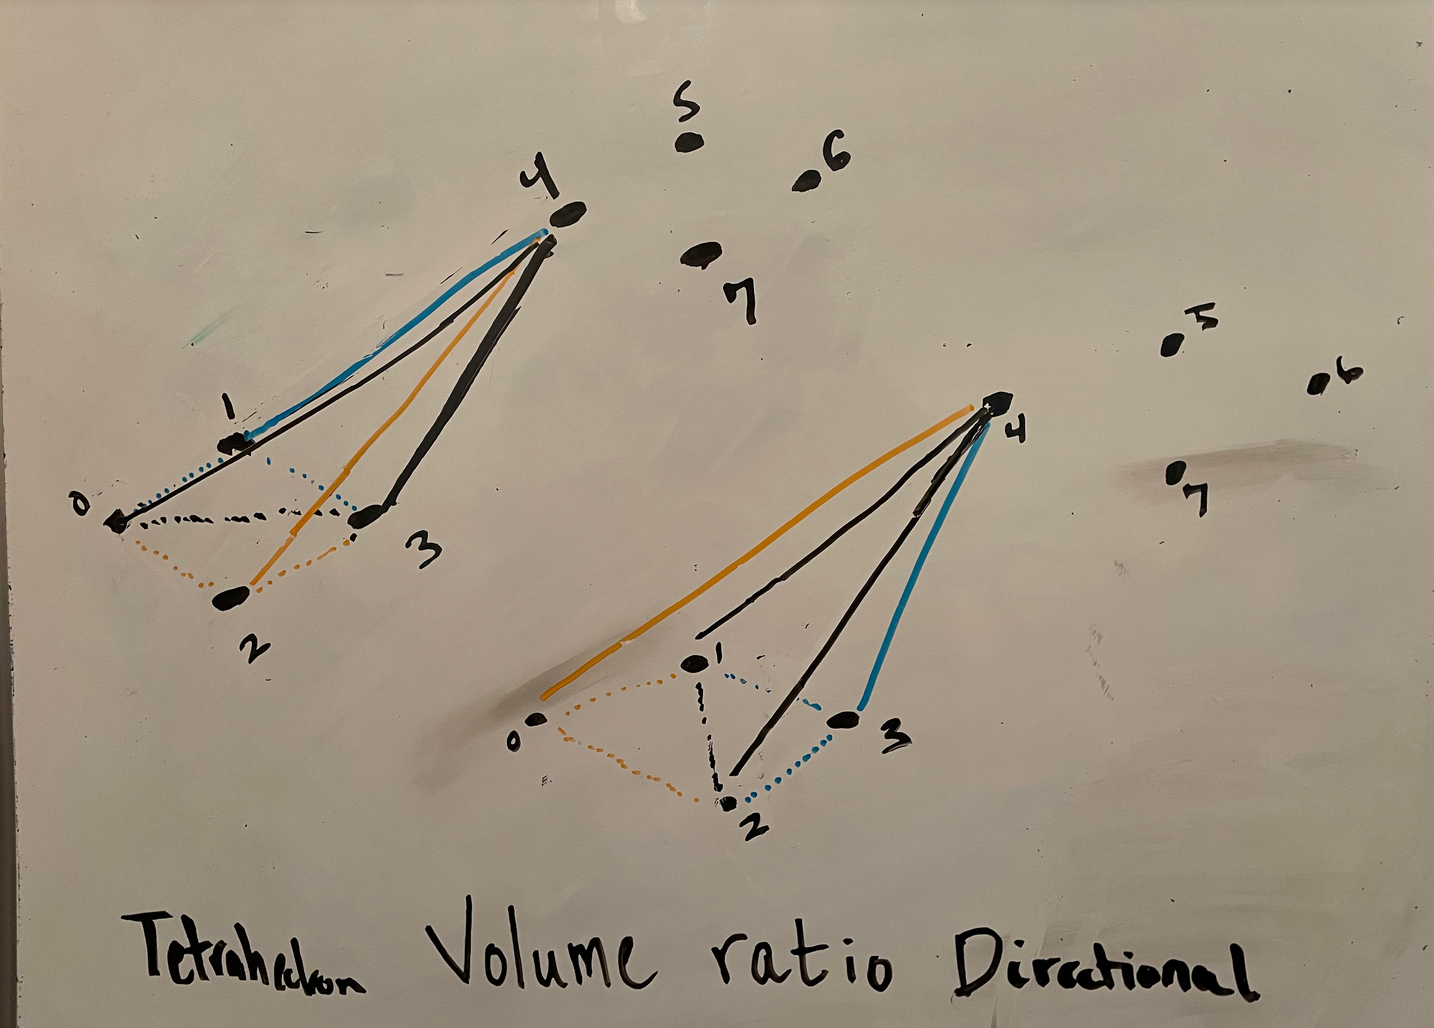

In [39]:
#tetrahedrons from helices 1 and 2 - points [0,1,2,3]
#to helices 3 and 4 - points [4,5,6,7]

ti_p = ti_p.reshape((-1,4,4))

ti_base = ti_p[:4]
ti_next = ti_p[4:]


In [43]:
#Match
#Base
#index  -   cross diagonal (point index)
#0/2            0,2 
#1/3            1,3

#Buttress

#4/6            4,6 
#5/7            5,7




In [23]:
tv = tetrahedron_volume(dist)
tv = tv.reshape((tv.shape[0],8,4))

In [24]:
# tv_purge = tv[np.sum(np.min(tv,axis=2)>1,axis=1)>7]
# tv_purge.shape

In [25]:
tv = tv.reshape((tv.shape[0],8,-1))


r1 = tv[:,0]/(tv[:,0]+tv[:,2])
r2 = tv[:,1]/(tv[:,1]+tv[:,3])
r3 = tv[:,4]/(tv[:,4]+tv[:,6])
r4 = tv[:,5]/(tv[:,5]+tv[:,7])

# new_rat_cond = ratio_1<10

# r1 = ratio_1[new_rat_cond]
# r2 = ratio_2[new_rat_cond]
# r3 = ratio_3[new_rat_cond]
# r4 = ratio_4[new_rat_cond]

In [36]:
tv.shape

(27877, 8, 4)

In [490]:
#need to rotate points into r02/r13 helical axis
#decide better metrics

In [20]:

# zp_ep_mp = rotate_base_tri_Zplane(ep_mp,  target_point=4, index_mobile=[0,1,2])#modded mobile
# zp_ep_mp2 = rotate_base_tri_Zplane(ep_mp,  target_point=4, index_mobile=[0,1,3])#modded mobile
# mp_vec = zp_ep_mp[:,9]-zp_ep_mp[:,8]
# mp_vec2 = zp_ep_mp2[:,9]-zp_ep_mp2[:,8]

# direction = mp_vec[:,:2]/np.linalg.norm(mp_vec[:,:2],axis=1).reshape((mp_vec.shape[0],1))
# magnitude = np.sqrt(np.square(mp_vec[:,1]) + np.square(mp_vec[:,0]))
# direction2 = mp_vec2[:,:2]/np.linalg.norm(mp_vec2[:,:2],axis=1).reshape((mp_vec.shape[0],1))
# magnitude2 = np.sqrt(np.square(mp_vec[:,1]) + np.square(mp_vec[:,0]))

In [18]:
ep_mp_xy = align_points_to_XYplane_F4(ep_mp,tp=4, keep_orig_trans=False)
#need to align tetrahedrons top to x plane


In [78]:
ep_mp_xy[0,9]

array([-0.5 , -0.75,  8.87])

In [87]:
ang = np.arctan(ep_mp_xy[:,9,1]/ep_mp_xy[:,9,0])

In [103]:
xf = []
axis=np.array([0,0,1])
for x in range(len(ang)):
    xf.append(nu.xform_from_axis_angle_rad(axis, ang[x]+np.pi/2))

In [104]:
xformR = np.array(xf)
R = xformR[:,0:3,0:3]
A_rot = np.matmul(ep_mp_xy, R)

In [105]:
np.round(A_rot[:,9],1)

array([[ 0. ,  0.9,  8.9],
       [-0. , -2. ,  8.6],
       [-0. ,  0.4,  8.8],
       ...,
       [ 0. , -5.2,  7.3],
       [ 0. , -2.3,  8.5],
       [ 0. , -2.1,  8.7]])

In [106]:
mp_vec = A_rot[:,9]-A_rot[:,8]
direction = mp_vec[:,:2]/np.linalg.norm(mp_vec[:,:2],axis=1).reshape((mp_vec.shape[0],1))
magnitude = np.sqrt(np.square(mp_vec[:,1]) + np.square(mp_vec[:,0]))

In [182]:
r1[:,0][:100]

array([0.5 , 0.53, 0.33, 0.21, 0.87, 0.25, 0.27, 0.4 , 0.24, 0.01, 0.21,
       0.04, 0.81, 0.06, 0.37, 0.51, 0.66, 0.51, 0.94, 0.61, 0.07, 0.59,
       0.49, 0.68, 0.06, 0.83, 0.18, 0.93, 0.42, 0.53, 0.55, 0.38, 0.05,
       0.27, 0.57, 0.18, 0.45, 0.41, 0.41, 0.2 , 0.4 , 0.28, 0.55, 0.66,
       0.61, 0.05, 0.98, 0.55, 0.45, 0.78, 0.45, 0.42, 0.37, 0.48, 0.35,
       0.02, 0.29, 0.52, 0.16, 0.01, 0.01, 0.43, 0.31, 0.39, 0.47, 0.52,
       0.51, 0.85, 0.21, 0.39, 0.55, 0.44, 0.5 , 0.46, 0.76, 0.36, 0.41,
       0.53, 0.58, 0.17, 0.26, 0.32, 0.49, 0.47, 0.57, 0.07, 0.25, 0.15,
       0.11, 0.08, 0.69, 0.6 , 0.35, 0.26, 0.05, 0.66, 0.32, 0.21, 0.23,
       0.22])

In [184]:
mp_vec[:,1][:100]

array([ 0.91, -1.97,  0.41, -3.47,  1.85,  4.72,  0.96,  4.23, -1.5 ,
       -3.43, -3.47, -2.61, -5.92, -4.19, -3.69, -1.7 ,  2.78,  6.44,
       -6.62, -3.81, -4.9 , -0.65, -4.81,  6.53,  2.51, -6.84, -2.11,
        6.53,  7.58,  7.02, -0.99,  1.25, -2.65,  0.17,  3.9 ,  1.13,
       -5.49,  3.25,  1.7 , -1.87,  2.67,  3.06,  5.48, -8.18, -3.73,
        5.32,  3.35, -3.37, -1.27, -5.09, -5.32,  2.23,  1.81,  4.04,
       -5.06,  1.96, -2.  , -3.99, -1.75,  0.77, -1.34,  8.36, -2.79,
        4.17, -2.13,  3.2 ,  1.95, -6.25, -3.  , -4.18, -2.78,  3.44,
       -2.3 ,  1.43,  4.53,  3.34,  2.77, -2.42,  3.47,  2.39,  1.95,
        3.93,  4.16,  3.49, -8.11, -3.85,  1.41, -1.21,  2.35,  1.87,
        3.8 ,  4.44,  1.6 ,  2.2 ,  3.46,  7.28, -1.87, -1.51,  2.02,
       -2.34])

In [178]:
ind=0
for x in range(4):
    print(np.corrcoef(np.mean(r1,axis=1), mp_vec[:,1]))
    print(np.corrcoef(np.mean(r2,axis=1), mp_vec[:,1]))
    print(np.corrcoef(np.mean(r3,axis=1), mp_vec[:,1]))
    print(np.corrcoef(np.mean(r4,axis=1), mp_vec[:,1]))

[[ 1.   -0.06]
 [-0.06  1.  ]]
[[1.   0.05]
 [0.05 1.  ]]
[[1. 0.]
 [0. 1.]]
[[1. 0.]
 [0. 1.]]
[[ 1.   -0.06]
 [-0.06  1.  ]]
[[1.   0.05]
 [0.05 1.  ]]
[[1. 0.]
 [0. 1.]]
[[1. 0.]
 [0. 1.]]
[[ 1.   -0.06]
 [-0.06  1.  ]]
[[1.   0.05]
 [0.05 1.  ]]
[[1. 0.]
 [0. 1.]]
[[1. 0.]
 [0. 1.]]
[[ 1.   -0.06]
 [-0.06  1.  ]]
[[1.   0.05]
 [0.05 1.  ]]
[[1. 0.]
 [0. 1.]]
[[1. 0.]
 [0. 1.]]


In [188]:
for x in range(4):
    print()
    print(np.corrcoef(r1[:,x], np.abs(mp_vec[:,1])))
    print(np.corrcoef(r2[:,x], np.abs(mp_vec[:,1])))
    print(np.corrcoef(r3[:,x], np.abs(mp_vec[:,1])))
    print(np.corrcoef(r4[:,x], np.abs(mp_vec[:,1])))
    print()


[[1.   0.19]
 [0.19 1.  ]]
[[ 1.   -0.16]
 [-0.16  1.  ]]
[[1.   0.05]
 [0.05 1.  ]]
[[1.   0.06]
 [0.06 1.  ]]


[[1.   0.08]
 [0.08 1.  ]]
[[ 1.   -0.05]
 [-0.05  1.  ]]
[[1.   0.05]
 [0.05 1.  ]]
[[ 1.   -0.16]
 [-0.16  1.  ]]


[[1.   0.07]
 [0.07 1.  ]]
[[ 1.   -0.16]
 [-0.16  1.  ]]
[[ 1.   -0.05]
 [-0.05  1.  ]]
[[ 1.   -0.08]
 [-0.08  1.  ]]


[[1.   0.19]
 [0.19 1.  ]]
[[ 1.   -0.06]
 [-0.06  1.  ]]
[[1.   0.04]
 [0.04 1.  ]]
[[ 1. -0.]
 [-0.  1.]]



In [60]:
magnitude

array([0.91, 1.97, 0.41, ..., 5.25, 2.26, 2.11])

In [47]:
np.corrcoef(np.mean(r1/r1,axis=1), direction[:,1])

C:\Users\nwoodall\.conda\envs\fa_tfpy\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\nwoodall\.conda\envs\fa_tfpy\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


array([[nan, nan],
       [nan,  1.]])

#### direction

In [489]:
np.max(np.max(r3/r1,axis=1))

23961.728617006207

In [34]:
r4[0]

array([0.64, 0.55, 0.64, 0.84])

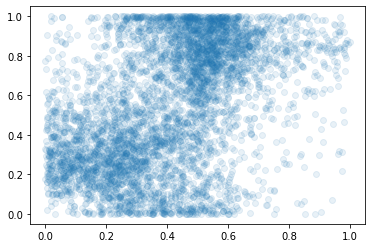

In [378]:
# tan-1(y/x)
import matplotlib.pyplot as plt




r11 = r1[:,0].reshape(-1, 1)
r12 = dir1[:,1].reshape(-1, 1)

#random sample
newSize = 5000
r1_, r2_ = zip(*random.sample(list(zip(r11, r12)), newSize))
r1_ = np.array(r1_) 
r2_ = np.array(r2_)


plt.scatter(r1_, r2_,alpha=0.1)

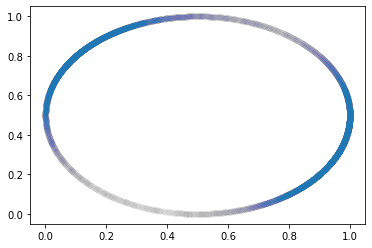

In [331]:
mm_d = MinMaxScaler(feature_range=(0,1))
dir1 = mm_mag.fit_transform(direction.reshape((-1, 2)))
plt.scatter(dir1[:,0], dir1[:,1],alpha=0.003)

In [359]:
np.sum((dir1[:,0]>0.5) & (np.mean(r1,axis=1)<0.5))

14355

In [368]:
np.sum((dir1[:,0]>0.1) & (r1[:,0]<0.1))

2431

In [367]:
np.sum((dir1[:,0]<0.1))

5519

In [128]:
np.mean(dir1[:,])

In [129]:
#random sample
newSize = 1000
direction, magnitude = zip(*random.sample(list(zip(direction, magnitude)), newSize))

In [130]:
direction=np.array(direction)
magnitude=np.array(magnitude)

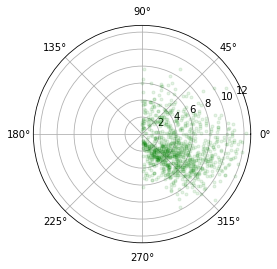

In [131]:

rads = np.arctan(np.divide(direction[:,1],direction[:,0]))
plt.polar(rads, magnitude, 'g.', alpha=0.1)

In [237]:
np.std(ratio_1)

4.162999628820449

In [286]:
tv = tv.reshape((tv_purge.shape[0],8,-1))


r1 = tv[:,0]/(tv[:,0]+tv[:,2])
r2 = tv[:,1]/(tv[:,1]+tv[:,3])
r3 = tv[:,4]/(tv[:,4]+tv[:,6])
r4 = tv[:,5]/(tv[:,5]+tv[:,7])

# new_rat_cond = ratio_1<10

# r1 = ratio_1[new_rat_cond]
# r2 = ratio_2[new_rat_cond]
# r3 = ratio_3[new_rat_cond]
# r4 = ratio_4[new_rat_cond]

In [277]:
np.max(np.max(r1,axis=1))

0.9980607271861193

In [251]:
direction_ratio = np.arctan(np.divide(r2,r1))
direction_magnitude = np.sqrt( np.square(r2) + np.square(r1))

In [252]:
np.mean(ratio_2)

3.506882777613631

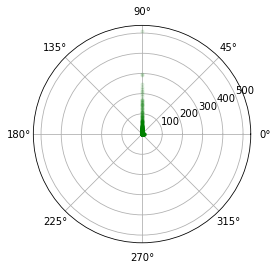

In [256]:
#random sample
newSize = 10000
direction_ratio1, direction_magnitude1 = zip(*random.sample(list(zip(direction_ratio, direction_magnitude)), newSize))


plt.polar(direction_ratio1, direction_magnitude1, 'g.', alpha=0.1)

In [280]:
direction
magnitude

array([4.23, 4.35, 3.31, ..., 6.41, 2.19, 3.73])

In [72]:
mp_vec[:,:2]

array([[ 2.48,  1.63],
       [ 3.99,  2.2 ],
       [-1.61,  1.48],
       ...,
       [ 3.83,  4.31],
       [ 2.18, -0.46],
       [ 1.1 ,  2.29]])

In [ ]:
def normalize(v):
    norm = np.linalg.norm(v)
    if norm == 0: 
        return v
    return v / norm

In [83]:
np.sqrt((0.84)**2+  (0.55)**2)

1.004041831797859

In [37]:
ti_p

array([[[0, 1, 2, 4],
        [0, 1, 2, 5],
        [0, 1, 2, 6],
        [0, 1, 2, 7]],

       [[0, 1, 3, 4],
        [0, 1, 3, 5],
        [0, 1, 3, 6],
        [0, 1, 3, 7]],

       [[0, 2, 3, 4],
        [0, 2, 3, 5],
        [0, 2, 3, 6],
        [0, 2, 3, 7]],

       [[1, 2, 3, 4],
        [1, 2, 3, 5],
        [1, 2, 3, 6],
        [1, 2, 3, 7]],

       [[4, 5, 6, 0],
        [4, 5, 6, 1],
        [4, 5, 6, 2],
        [4, 5, 6, 3]],

       [[4, 5, 7, 0],
        [4, 5, 7, 1],
        [4, 5, 7, 2],
        [4, 5, 7, 3]],

       [[4, 6, 7, 0],
        [4, 6, 7, 1],
        [4, 6, 7, 2],
        [4, 6, 7, 3]],

       [[5, 6, 7, 0],
        [5, 6, 7, 1],
        [5, 6, 7, 2],
        [5, 6, 7, 3]]])

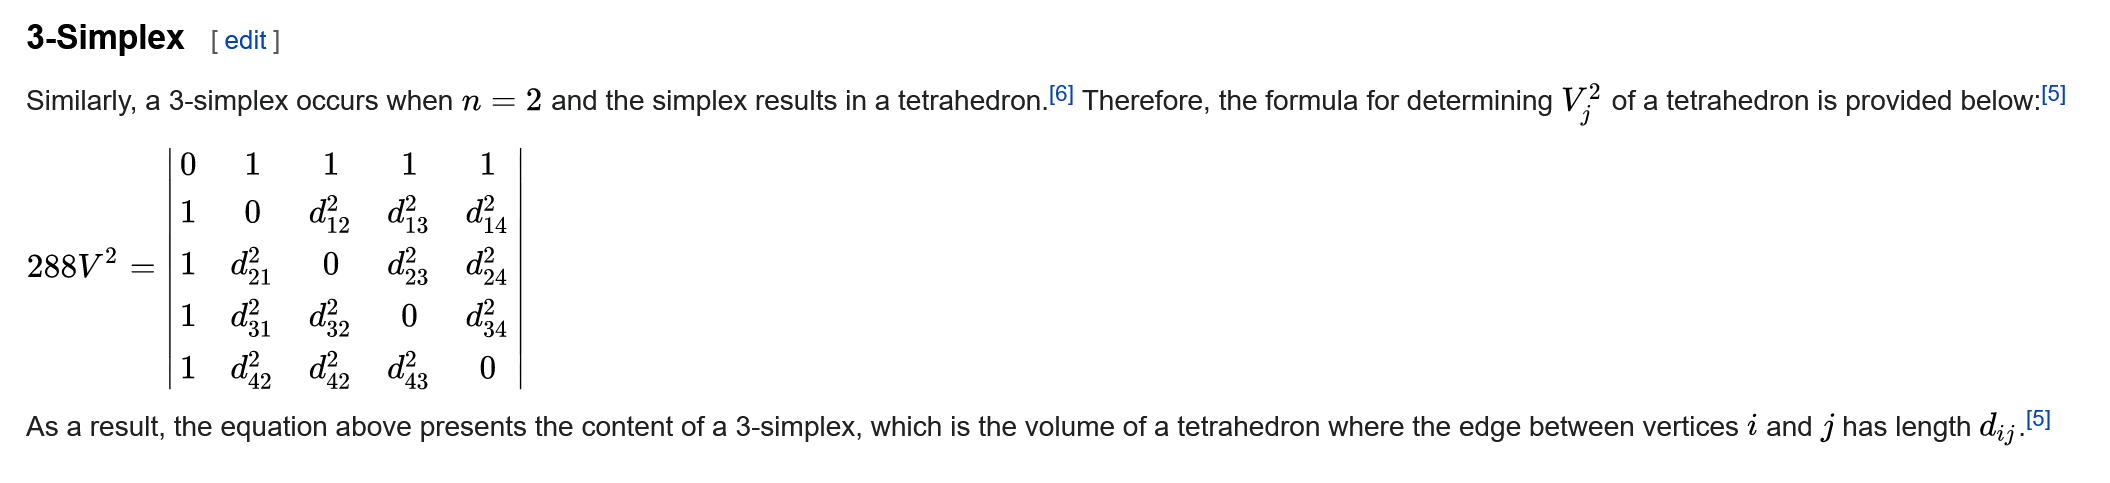